(imports and functions)

In [11]:

### import libraries
import pandas as pd,numpy as np,os
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import normalize

print("importing")

importing


In [3]:
def map_new_to_old_style(sequence):
    types = []
    landmark_indexes = []
    for column in list(sequence.columns)[1:544]:
        parts = column.split("_")
        if len(parts) == 4:
            types.append(parts[1] + "_" + parts[2])
        else:
            types.append(parts[1])

        landmark_indexes.append(int(parts[-1]))

    data = {
        "frame": [],
        "type": [],
        "landmark_index": [],
        "x": [],
        "y": [],
        "z": []
    }

    for index, row in sequence.iterrows():
        data["frame"] += [int(row.frame)]*543
        data["type"] += types
        data["landmark_index"] += landmark_indexes

        for _type, landmark_index in zip(types, landmark_indexes):
            data["x"].append(row[f"x_{_type}_{landmark_index}"])
            data["y"].append(row[f"y_{_type}_{landmark_index}"])
            data["z"].append(row[f"z_{_type}_{landmark_index}"])

    return pd.DataFrame.from_dict(data)

# assign desired colors to landmarks
def assign_color(row):
    if row == 'face':
        return 'red'
    elif 'hand' in row:
        return 'dodgerblue'
    else:
        return 'green'

# specifies the plotting order
def assign_order(row):
    if row.type == 'face':
        return row.landmark_index + 101
    elif row.type == 'pose':
        return row.landmark_index + 30
    elif row.type == 'left_hand':
        return row.landmark_index + 80
    else:
        return row.landmark_index
    
def visualise2d_landmarks(parquet_df, title="",inter_frame_delay : int = 100):
    connections = [  
        [0, 1, 2, 3, 4,],
        [0, 5, 6, 7, 8],
        [0, 9, 10, 11, 12],
        [0, 13, 14, 15, 16],
        [0, 17, 18, 19, 20],

        
        [38, 36, 35, 34, 30, 31, 32, 33, 37],
        [40, 39],
        [52, 46, 50, 48, 46, 44, 42, 41, 43, 45, 47, 49, 45, 51],
        [42, 54, 56, 58, 60, 62, 58],
        [41, 53, 55, 57, 59, 61, 57],
        [54, 53],

        
        [80, 81, 82, 83, 84, ],
        [80, 85, 86, 87, 88],
        [80, 89, 90, 91, 92],
        [80, 93, 94, 95, 96],
        [80, 97, 98, 99, 100], ]

    parquet_df = map_new_to_old_style(parquet_df)
    frames = sorted(set(parquet_df.frame))
    first_frame = min(frames)
    parquet_df['color'] = parquet_df.type.apply(lambda row: assign_color(row))
    parquet_df['plot_order'] = parquet_df.apply(lambda row: assign_order(row), axis=1)
    first_frame_df = parquet_df[parquet_df.frame == first_frame].copy()
    first_frame_df = first_frame_df.sort_values(["plot_order"]).set_index('plot_order')


    frames_l = []
    for frame in frames:
        filtered_df = parquet_df[parquet_df.frame == frame].copy()
        filtered_df = filtered_df.sort_values(["plot_order"]).set_index("plot_order")
        traces = [go.Scatter(
            x=filtered_df['x'],
            y=filtered_df['y'],
            mode='markers',
            marker=dict(
                color=filtered_df.color,
                size=9))]

        for i, seg in enumerate(connections):
            trace = go.Scatter(
                    x=filtered_df.loc[seg]['x'],
                    y=filtered_df.loc[seg]['y'],
                    mode='lines',
            )
            traces.append(trace)
        frame_data = go.Frame(data=traces, traces = [i for i in range(17)])
        frames_l.append(frame_data)

    traces = [go.Scatter(
        x=first_frame_df['x'],
        y=first_frame_df['y'],
        mode='markers',
        marker=dict(
            color=first_frame_df.color,
            size=9
        )
    )]
    for i, seg in enumerate(connections):
        trace = go.Scatter(
            x=first_frame_df.loc[seg]['x'],
            y=first_frame_df.loc[seg]['y'],
            mode='lines',
            line=dict(
                color='black',
                width=2
            )
        )
        traces.append(trace)
    
    fig = go.Figure(
            data=traces,
            frames=frames_l
        )

    fig.update_layout(
        width=500,
        height=800,
        scene={
            'aspectmode': 'data',
        },
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": [None, {"frame": {"duration": inter_frame_delay,
                                                  "redraw": True},
                                        "fromcurrent": True,
                                        "transition": {"duration": 0}}],
                        "label": "&#9654;",
                        "method": "animate",
                    },
                    {
                        "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                          "mode": "immediate",
                                          "transition": {"duration": 0}}],
                        "label": "&#9612;&#9612;",
                        "method": "animate",
                    },
                ],
                "direction": "left",
                "pad": {"r": 100, "t": 100},
                "font": {"size":20},
                "type": "buttons",
                "x": 0.1,
                "y": 0,
            }
        ],
    )
    camera = dict(
        up=dict(x=0, y=-1, z=0),
        eye=dict(x=0, y=0, z=2.5)
    )
    fig.update_layout(title_text=title, title_x=0.5)
    fig.update_layout(scene_camera=camera, showlegend=False)
    fig.update_layout(xaxis = dict(visible=False),
            yaxis = dict(visible=False),
    )
    fig.update_yaxes(autorange="reversed")

    fig.show()
    
    
def get_phrase(df, file_id, sequence_id):
    return df[
        np.logical_and(
            df.file_id == file_id, 
            df.sequence_id == sequence_id
        )
    ].phrase.iloc[0]


# Goal of this notebook

The aim of this notebook is to help me to:
* Understand the representation of the signs in the dataset,
* Get something simple that I can train a basic neural network with.

The ideal outcome would be series of examples of "this represents 'a'", "this is  a 'b'"

## GOAL OF COMPETITION

The goal of this competition is to detect and translate American Sign Language (ASL) fingerspelling into text. You will create a model trained on the largest dataset of its kind, released specifically for this competition. The data includes more than three million fingerspelled characters produced by over 100 Deaf signers captured via the selfie camera of a smartphone with a variety of backgrounds and lighting conditions

* Your work may help move sign language recognition forward, making AI more accessible for the Deaf and Hard of Hearing community. 

<img src="https://www.lifeprint.com/asl101/fingerspelling/images/signlanguageabc.jpg" width="400">

# Exploring the training data

First let's read in and inspect the training data legend or key:

In [4]:
data = pd.read_csv("input/train.csv", delimiter=',', encoding='UTF-8')
pd.set_option('display.max_columns', None)
data.head(3)


,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816862427,0,hentaihubs.com


Let's try to visualise the first phrase in the training data `3 creekhouse` - which is sequence ID `1816796431`

Apparently it's somewhere in `train_landmarks/5414471.parquet`

In [5]:
phrase_string = data.loc[data["sequence_id"] == 1816796431].phrase.values[0]

phrases = pd.read_parquet("input/train_landmarks/5414471.parquet")
phrases.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4   
sequence_id                                                            
1816796431       0  0.710588  0.699951  0.705657  0.691768  0.699669  \
1816796431       1  0.709525  0.697582  0.703713  0.691016  0.697576   
1816796431       2  0.711059  0.700858  0.706272  0.693285  0.700825   
1816796431       3  0.712799  0.702518  0.707840  0.694899  0.702445   
1816796431       4  0.712349  0.705451  0.709918  0.696006  0.705180   

             x_face_5  x_face_6  x_face_7  x_face_8  x_face_9  x_face_10   
sequence_id                                                                
1816796431   0.701980  0.709724  0.610405  0.712660  0.713004   0.716668  \
1816796431   0.700467  0.709796  0.616540  0.713729  0.714435   0.719558   
1816796431   0.703319  0.711549  0.615606  0.715143  0.715867   0.720836   
1816796431   0.704794  0.712483  0.625044  0.715677  0.716231   0.720678   
1816796431   0.706928  0.712685  0.614356  0.714875  0.715110   0.717710   

             x_face_11  x_face_12  x_face_13  x_face_14  x_face_15  x_face_16   
sequence_id                                                                     
1816796431    0.710871   0.711406   0.712219   0.711857   0.711868   0.712037  \
1816796431    0.709844   0.710382   0.711181   0.710837   0.710657   0.710658   
1816796431    0.711340   0.711864   0.712644   0.712346   0.712275   0.712357   
1816796431    0.712962   0.713302   0.713885   0.713480   0.713300   0.713208   
1816796431    0.712470   0.712828   0.713431   0.712995   0.712710   0.712452   

             x_face_17  x_face_18  x_face_19  x_face_20  x_face_21  x_face_22   
sequence_id                                                                     
1816796431    0.712642   0.710864   0.701962   0.690785   0.574435   0.652201  \
1816796431    0.711053   0.706864   0.699644   0.688590   0.580494   0.655051   
1816796431    0.712808   0.709137   0.702700   0.691392   0.577924   0.654188   
1816796431    0.713368   0.709939   0.704363   0.693143   0.580396   0.663229   
1816796431    0.712426   0.711674   0.707145   0.695490   0.571968   0.655560   

             x_face_23  x_face_24  x_face_25  x_face_26  x_face_27  x_face_28   
sequence_id                                                                     
1816796431    0.637868   0.623929   0.604830   0.664349   0.629179   0.645488  \
1816796431    0.641654   0.628472   0.610501   0.666192   0.635521   0.650769   
1816796431    0.640510   0.627165   0.609320   0.665847   0.635727   0.650842   
1816796431    0.649336   0.635868   0.618672   0.674972   0.641881   0.657203   
1816796431    0.640964   0.626806   0.608233   0.667761   0.633646   0.650139   

             x_face_29  x_face_30  x_face_31  x_face_32  x_face_33  x_face_34   
sequence_id                                                                     
1816796431    0.613881   0.604104   0.595274   0.655572   0.605329   0.567962  \
1816796431    0.620963   0.611418   0.600352   0.652655   0.611691   0.572913   
1816796431    0.621108   0.611211   0.598542   0.653407   0.610695   0.569467   
1816796431    0.627606   0.618491   0.606223   0.655135   0.620123   0.572598   
1816796431    0.618022   0.607935   0.596722   0.656564   0.609164   0.566100   

             x_face_35  x_face_36  x_face_37  x_face_38  x_face_39  x_face_40   
sequence_id                                                                     
1816796431    0.582004   0.635376   0.691068   0.694257   0.672491   0.659999  \
1816796431    0.588026   0.635606   0.689966   0.693362   0.671613   0.659798   
1816796431    0.585980   0.636610   0.691479   0.694764   0.672846   0.660680   
1816796431    0.592384   0.639424   0.693746   0.696692   0.675276   0.663020   
1816796431    0.583412   0.638292   0.693101   0.695989   0.674172   0.661701   

             x_face_41  x_face_42  x_face_43  x_face_44  x_face_45  x_face_46   
sequence_id                                           

The parquet is a sequence of co-oridinates, organised by the video frame and the phrase the person was signing.

Let's get out a phrase to inspect in more detail, so we can mess with that in isolation:

In [6]:
target_phrase = phrases.loc[1816796431]
target_phrase.head(10)

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4   
sequence_id                                                            
1816796431       0  0.710588  0.699951  0.705657  0.691768  0.699669  \
1816796431       1  0.709525  0.697582  0.703713  0.691016  0.697576   
1816796431       2  0.711059  0.700858  0.706272  0.693285  0.700825   
1816796431       3  0.712799  0.702518  0.707840  0.694899  0.702445   
1816796431       4  0.712349  0.705451  0.709918  0.696006  0.705180   
1816796431       5  0.711748  0.704973  0.709408  0.695329  0.704640   
1816796431       6  0.714870  0.705515  0.709861  0.695941  0.705266   
1816796431       7  0.715551  0.706797  0.710931  0.697779  0.706758   
1816796431       8  0.715828  0.707237  0.711591  0.698787  0.707189   
1816796431       9  0.712654  0.706442  0.711294  0.698016  0.706404   

             x_face_5  x_face_6  x_face_7  x_face_8  x_face_9  x_face_10   
sequence_id                                                                
1816796431   0.701980  0.709724  0.610405  0.712660  0.713004   0.716668  \
1816796431   0.700467  0.709796  0.616540  0.713729  0.714435   0.719558   
1816796431   0.703319  0.711549  0.615606  0.715143  0.715867   0.720836   
1816796431   0.704794  0.712483  0.625044  0.715677  0.716231   0.720678   
1816796431   0.706928  0.712685  0.614356  0.714875  0.715110   0.717710   
1816796431   0.706208  0.711463  0.614758  0.713350  0.713433   0.715530   
1816796431   0.706928  0.712595  0.610731  0.714953  0.715308   0.718290   
1816796431   0.708641  0.714777  0.615837  0.717535  0.718140   0.722129   
1816796431   0.709235  0.715876  0.618959  0.718716  0.719266   0.723162   
1816796431   0.708503  0.715396  0.616198  0.718394  0.719042   0.723659   

             x_face_11  x_face_12  x_face_13  x_face_14  x_face_15  x_face_16   
sequence_id                                                                     
1816796431    0.710871   0.711406   0.712219   0.711857   0.711868   0.712037  \
1816796431    0.709844   0.710382   0.711181   0.710837   0.710657   0.710658   
1816796431    0.711340   0.711864   0.712644   0.712346   0.712275   0.712357   
1816796431    0.712962   0.713302   0.713885   0.713480   0.713300   0.713208   
1816796431    0.712470   0.712828   0.713431   0.712995   0.712710   0.712452   
1816796431    0.711750   0.712091   0.712725   0.712520   0.711908   0.711302   
1816796431    0.714882   0.715073   0.715489   0.715280   0.714867   0.714377   
1816796431    0.715509   0.715638   0.716030   0.715790   0.715346   0.714803   
1816796431    0.715837   0.716087   0.716621   0.716665   0.716384   0.716077   
1816796431    0.712937   0.713617   0.714649   0.714565   0.714496   0.714651   

             x_face_17  x_face_18  x_face_19  x_face_20  x_face_21  x_face_22   
sequence_id                                                                     
1816796431    0.712642   0.710864   0.701962   0.690785   0.574435   0.652201  \
1816796431    0.711053   0.706864   0.699644   0.688590   0.580494   0.655051   
1816796431    0.712808   0.709137   0.702700   0.691392   0.577924   0.654188   
1816796431    0.713368   0.709939   0.704363   0.693143   0.580396   0.663229   
1816796431    0.712426   0.711674   0.707145   0.695490   0.571968   0.655560   
1816796431    0.710992   0.711565   0.706686   0.695163   0.572269   0.655268   
1816796431    0.714107   0.711482   0.707178   0.695539   0.572897   0.654037   
1816796431    0.714456   0.711464   0.708324   0.696530   0.576277   0.658875   
1816796431    0.716045   0.713004   0.708827   0.697337   0.579713   0.659408   
1816796431    0.715277   0.713701   0.708120   0.696921   0.577973   0.658478   

             x_face_23  x_face_24  x_face_25  x_face_26  x_face_27  x_face_28   
sequence_id                                                                     
1816796431    0.637868   0.623929   0.604830   0.664349   0.629179   0.645488  \
1816796431    0.641654   0.628472   0.610501  

The phrase itself then is the co-ordinates of the person signing our phase, and can be animated with a [complex function I've shamelessly stolen from another user](https://www.kaggle.com/code/sharifi76/eda-motion-visualization-fingerspelling)

In [12]:
visualise2d_landmarks(target_phrase, f"Phrase: {phrase_string}", inter_frame_delay=200)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

OK, so we have some frames that correspond to the phrase. Let's look at the hands specifically:

In [13]:
target_phrase.head(10).filter(regex="hand|frame")

,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,x_left_hand_9,x_left_hand_10,x_left_hand_11,x_left_hand_12,x_left_hand_13,x_left_hand_14,x_left_hand_15,x_left_hand_16,x_left_hand_17,x_left_hand_18,x_left_hand_19,x_left_hand_20,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,x_right_hand_9,x_right_hand_10,x_right_hand_11,x_right_hand_12,x_right_hand_13,x_right_hand_14,x_right_hand_15,x_right_hand_16,x_right_hand_17,x_right_hand_18,x_right_hand_19,x_right_hand_20,y_left_hand_0,y_left_hand_1,y_left_hand_2,y_left_hand_3,y_left_hand_4,y_left_hand_5,y_left_hand_6,y_left_hand_7,y_left_hand_8,y_left_hand_9,y_left_hand_10,y_left_hand_11,y_left_hand_12,y_left_hand_13,y_left_hand_14,y_left_hand_15,y_left_hand_16,y_left_hand_17,y_left_hand_18,y_left_hand_19,y_left_hand_20,y_right_hand_0,y_right_hand_1,y_right_hand_2,y_right_hand_3,y_right_hand_4,y_right_hand_5,y_right_hand_6,y_right_hand_7,y_right_hand_8,y_right_hand_9,y_right_hand_10,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,z_left_hand_0,z_left_hand_1,z_left_hand_2,z_left_hand_3,z_left_hand_4,z_left_hand_5,z_left_hand_6,z_left_hand_7,z_left_hand_8,z_left_hand_9,z_left_hand_10,z_left_hand_11,z_left_hand_12,z_left_hand_13,z_left_hand_14,z_left_hand_15,z_left_hand_16,z_left_hand_17,z_left_hand_18,z_left_hand_19,z_left_hand_20,z_right_hand_0,z_right_hand_1,z_right_hand_2,z_right_hand_3,z_right_hand_4,z_right_hand_5,z_right_hand_6,z_right_hand_7,z_right_hand_8,z_right_hand_9,z_right_hand_10,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1816796431,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.408832,0.519912,0.612159,0.707576,0.797313,0.494709,0.532817,0.553556,0.566219,0.391196,0.346564,0.329398,0.310256,0.303476,0.332645,0.407769,0.452754,0.241267,0.302987,0.372977,0.413130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.828362,0.797813,0.729445,0.693900,0.677417,0.642394,0.556336,0.501643,0.452985,0.648080,0.552678,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,-0.065295,-0.099489,-0.134330,-0.169376,-0.093553,-0.157288,-0.193133,-0.217873,-0.109475,-0.196916,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Mostly we have no hand co-ordinates, which matches our prior visualisation.

Can we detect pauses or similar so we can guess at letters?

In [14]:
#let's first get rid of the useless columns - as our speller should be using only one hand
hands = target_phrase.filter(regex="hand|frame").copy()
hands = hands.dropna(axis=1,how="all")

#then add a "group" column to see how many "pauses" we have where there's no detection

hands["group_no"] = hands.filter(regex="hand").isna().all(axis=1).cumsum()

#we can then drop the "pauses", using thresholds as we've no longer got a whole row of nans
hands = hands.dropna(axis=0,thresh=20)
hands.head()

,frame,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,x_right_hand_9,x_right_hand_10,x_right_hand_11,x_right_hand_12,x_right_hand_13,x_right_hand_14,x_right_hand_15,x_right_hand_16,x_right_hand_17,x_right_hand_18,x_right_hand_19,x_right_hand_20,y_right_hand_0,y_right_hand_1,y_right_hand_2,y_right_hand_3,y_right_hand_4,y_right_hand_5,y_right_hand_6,y_right_hand_7,y_right_hand_8,y_right_hand_9,y_right_hand_10,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,z_right_hand_0,z_right_hand_1,z_right_hand_2,z_right_hand_3,z_right_hand_4,z_right_hand_5,z_right_hand_6,z_right_hand_7,z_right_hand_8,z_right_hand_9,z_right_hand_10,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20,group_no
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.408832,0.519912,0.612159,0.707576,0.797313,0.494709,0.532817,0.553556,0.566219,0.391196,0.346564,0.329398,0.310256,0.303476,0.332645,0.407769,0.452754,0.241267,0.302987,0.372977,0.413130,0.828362,0.797813,0.729445,0.693900,0.677417,0.642394,0.556336,0.501643,0.452985,0.648080,0.552678,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,0.000001,-0.065295,-0.099489,-0.134330,-0.169376,-0.093553,-0.157288,-0.193133,-0.217873,-0.109475,-0.196916,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876,0
1816796431,3,0.398663,0.523662,0.638807,0.744236,0.832567,0.538486,0.564302,0.581011,0.597674,0.441541,0.429515,0.441297,0.453220,0.355269,0.407275,0.455842,0.488949,0.292710,0.351343,0.406092,0.442418,0.805901,0.796239,0.744409,0.715357,0.681418,0.652149,0.591903,0.539250,0.494978,0.645438,0.578784,0.528952,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,0.000002,-0.082688,-0.143600,-0.197512,-0.251108,-0.158306,-0.246869,-0.299608,-0.336924,-0.171088,-0.301972,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282,2
1816796431,12,0.419290,0.509726,0.593165,0.685492,0.777913,0.483669,0.510993,0.536410,0.564583,0.393016,0.382989,0.413281,0.449161,0.318446,0.378528,0.484440,0.568851,0.265254,0.345995,0.435894,0.506857,0.815355,0.797622,0.742897,0.711665,0.693214,0.650615,0.575589,0.528461,0.487134,0.656149,0.574237,0.523051,0.477154,0.684504,0.644122,0.671142,0.694155,0.728935,0.714686,0.734443,0.748464,0.000002,-0.070057,-0.119156,-0.165951,-0.213557,-0.115064,-0.191421,-0.239379,-0.273761,-0.132532,-0.229315,-0.285770,-0.318548,-0.155317,-0.274822,-0.312119,-0.316411,-0.181363,-0.286298,-0.316182,-0.322671,10
1816796431,13,0.398764,0.498118,0.583356,0.677779,0.775966,0.481279,0.491659,0.524974,0.571944,0.412262,0.406226,0.455482,0.513893,0.351730,0.368051,0.442332,0.511890,0.305196,0.331533,0.383946,0.434939,0.810161,0.775277,0.725558,0.707280,0.697369,0.630440,0.559574,0.524462,0.499123,0.643037,0.558959,0.520018,0.493038,0.675656,0.609540,0.592604,0.581233,0.720590,0.676444,0.659086,0.642554,0.000002,-0.051467,-0.102596,-0.154688,-0.211317,-0.093985,-0.170331,-0.223637,-0.257890,-0.114926,-0.187131,-0.235725,-0.267054,-0.141380,-0.219369,-0.256553,-0.273690,-0.170996,-0.240285,-0.266193,-0.278110,10
1816796431,14,0.420213,0.495650,0.571790,0.659049,0.749740,0.485707,0.475930,0.501727,0.539150,0.438294,0.436278,0.477189,0.530308,0.389410,0.398087,0.431037,0.473678,0.339603,0.344246,0.369611,0.403788,0.793506,0.769774,0.718986,0.699733,0.689401,0.638051,0.575092,0.537075,0.510697,0.640987,0.575008,0.536444,0.512108,0.658050,0.591214,0.550912,0.522875,0.687227,0.631696,0.592241,0.562679,0.000001,-0.048765,-0.088109,-0.125500,-0.168962,-0.073426,-0.133125,-0.179952,-0.212087,-0.087533,-0.143674,-0.186706,-0.217

In [15]:
letter_groups = hands.group_no.nunique()
print(f"detected {letter_groups} separate signs.")
print(f"The target phrase '3 creekhouse' has {len('3 creekhouse')} letters")
print(f"The target phrase '3 creekhouse' has {len(set('3 creekhouse'))} unique letters")

detected 5 separate signs.
The target phrase '3 creekhouse' has 12 letters
The target phrase '3 creekhouse' has 10 unique letters


Obviously this method of detecting which sign matches which letter will not work. 

# Clustering to extract single letter signs

we know there should be 9 unique letters (igoring the space), if we treat each dataframe row as an embedding, can we cluster the data into 9 broad groups?

First let's do a scree plot to find the dimensionality for PCA for the clustering

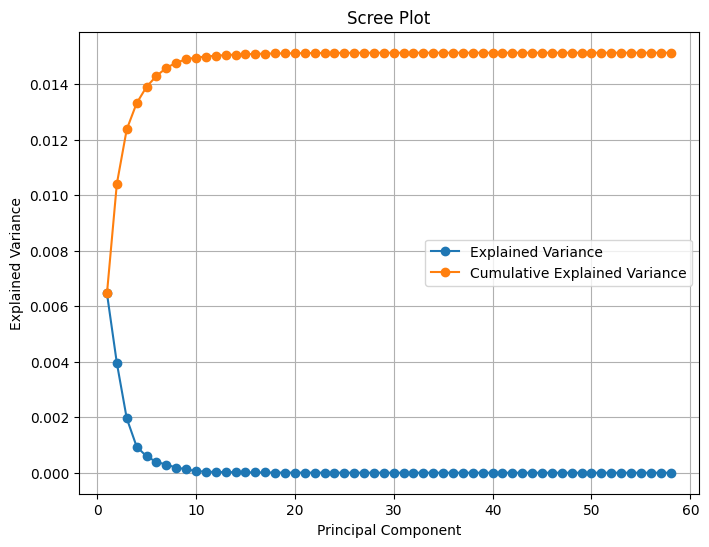

In [16]:
feat = hands.filter(regex="hand").to_numpy()
feat = normalize(feat)
n_components = min(feat.shape)
pca  = PCA(n_components=n_components)
pca.fit(feat)

explained_variance = pca.explained_variance_
cumulative_explained_variance = np.cumsum(explained_variance)
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components + 1), explained_variance, marker='o', linestyle='-', label='Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-', label='Cumulative Explained Variance')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Scree Plot')
plt.legend()
plt.grid()

Looks like this is 10 dimensional

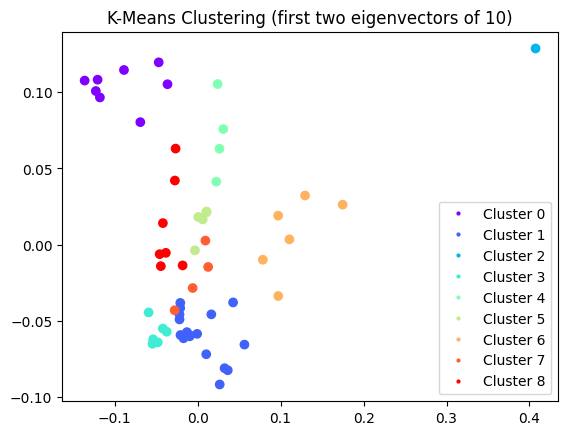

In [17]:
pca = PCA(n_components=10)
pca.fit(feat)
x = pca.transform(feat)

kmeans = KMeans(n_clusters=9,n_init="auto")
kmeans.fit(x)

unique_labels = np.unique(kmeans.labels_)
cmap = ListedColormap(plt.cm.rainbow(np.linspace(0, 1, len(unique_labels))))

plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_, cmap=cmap)
plt.title("K-Means Clustering (first two eigenvectors of 10)")


handles = [plt.Line2D([], [], linestyle='', marker='o', markersize=2, color=cmap(i), label=f'Cluster {label}') for i, label in enumerate(unique_labels)]
plt.legend(handles=handles)


plt.show()

Looks kind of clustered. Maybe.

Let's see what it says these signs look like:

In [18]:
hands["Sign Group"] = kmeans.labels_
    
hands.head()

,frame,x_right_hand_0,x_right_hand_1,x_right_hand_2,x_right_hand_3,x_right_hand_4,x_right_hand_5,x_right_hand_6,x_right_hand_7,x_right_hand_8,x_right_hand_9,x_right_hand_10,x_right_hand_11,x_right_hand_12,x_right_hand_13,x_right_hand_14,x_right_hand_15,x_right_hand_16,x_right_hand_17,x_right_hand_18,x_right_hand_19,x_right_hand_20,y_right_hand_0,y_right_hand_1,y_right_hand_2,y_right_hand_3,y_right_hand_4,y_right_hand_5,y_right_hand_6,y_right_hand_7,y_right_hand_8,y_right_hand_9,y_right_hand_10,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,z_right_hand_0,z_right_hand_1,z_right_hand_2,z_right_hand_3,z_right_hand_4,z_right_hand_5,z_right_hand_6,z_right_hand_7,z_right_hand_8,z_right_hand_9,z_right_hand_10,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20,group_no,Sign Group
sequence_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.408832,0.519912,0.612159,0.707576,0.797313,0.494709,0.532817,0.553556,0.566219,0.391196,0.346564,0.329398,0.310256,0.303476,0.332645,0.407769,0.452754,0.241267,0.302987,0.372977,0.413130,0.828362,0.797813,0.729445,0.693900,0.677417,0.642394,0.556336,0.501643,0.452985,0.648080,0.552678,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,0.000001,-0.065295,-0.099489,-0.134330,-0.169376,-0.093553,-0.157288,-0.193133,-0.217873,-0.109475,-0.196916,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876,0,6
1816796431,3,0.398663,0.523662,0.638807,0.744236,0.832567,0.538486,0.564302,0.581011,0.597674,0.441541,0.429515,0.441297,0.453220,0.355269,0.407275,0.455842,0.488949,0.292710,0.351343,0.406092,0.442418,0.805901,0.796239,0.744409,0.715357,0.681418,0.652149,0.591903,0.539250,0.494978,0.645438,0.578784,0.528952,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,0.000002,-0.082688,-0.143600,-0.197512,-0.251108,-0.158306,-0.246869,-0.299608,-0.336924,-0.171088,-0.301972,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282,2,6
1816796431,12,0.419290,0.509726,0.593165,0.685492,0.777913,0.483669,0.510993,0.536410,0.564583,0.393016,0.382989,0.413281,0.449161,0.318446,0.378528,0.484440,0.568851,0.265254,0.345995,0.435894,0.506857,0.815355,0.797622,0.742897,0.711665,0.693214,0.650615,0.575589,0.528461,0.487134,0.656149,0.574237,0.523051,0.477154,0.684504,0.644122,0.671142,0.694155,0.728935,0.714686,0.734443,0.748464,0.000002,-0.070057,-0.119156,-0.165951,-0.213557,-0.115064,-0.191421,-0.239379,-0.273761,-0.132532,-0.229315,-0.285770,-0.318548,-0.155317,-0.274822,-0.312119,-0.316411,-0.181363,-0.286298,-0.316182,-0.322671,10,6
1816796431,13,0.398764,0.498118,0.583356,0.677779,0.775966,0.481279,0.491659,0.524974,0.571944,0.412262,0.406226,0.455482,0.513893,0.351730,0.368051,0.442332,0.511890,0.305196,0.331533,0.383946,0.434939,0.810161,0.775277,0.725558,0.707280,0.697369,0.630440,0.559574,0.524462,0.499123,0.643037,0.558959,0.520018,0.493038,0.675656,0.609540,0.592604,0.581233,0.720590,0.676444,0.659086,0.642554,0.000002,-0.051467,-0.102596,-0.154688,-0.211317,-0.093985,-0.170331,-0.223637,-0.257890,-0.114926,-0.187131,-0.235725,-0.267054,-0.141380,-0.219369,-0.256553,-0.273690,-0.170996,-0.240285,-0.266193,-0.278110,10,6
1816796431,14,0.420213,0.495650,0.571790,0.659049,0.749740,0.485707,0.475930,0.501727,0.539150,0.438294,0.436278,0.477189,0.530308,0.389410,0.398087,0.431037,0.473678,0.339603,0.344246,0.369611,0.403788,0.793506,0.769774,0.718986,0.699733,0.689401,0.638051,0.575092,0.537075,0.510697,0.640987,0.575008,0.536444,0.512108,0.658050,0.591214,0.550912,0.522875,0.687227,0.631696,0.592241,0.562679,0.000001,-0.048765,-0.088109,-0.125500,-0.168962,-0.073426,-0.133125,-0.179952,-0.212087,-0.087533,-0.143

In [20]:
hands.iloc[1].frame

3.0

OK, so we have the cluster label for each "letter" in the sequence. Let's see if that makes broad sense given:
* Our sequence should say "3 creekhouse"
* We should have different groupings for the first 4 symbols
* The 4th symbol should be the same as the last.

In [ ]:
print("all labels")
print(kmeans.labels_)
cipher = []
#let's only keep labels found in consecutive detections - discarding others as noise
for i, element in enumerate(kmeans.labels_):
    if len(cipher) == 0 or (i+1 < len(kmeans.labels_) and element == kmeans.labels_[i+1] and element != cipher[-1]):
        cipher.append(element)
        

print("Repeated labels")
print(cipher)

all labels
[7 7 7 5 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 1 1 1 1 1 6 6 6 6 6 6 6 2
 2 2 2 8 8 8 8 8 0 0 0 0 0 3 3 3 3 5 5 5 4]
Repeated labels
[7, 3, 0, 1, 6, 2, 8, 0, 3, 5]


So now we have our crude cipher,but there's no sybol at the beginning that's not at the end... it's a bit of a jumbled up mess. If we  try the simple substitution translation we get:

In [ ]:
unique_string = ""
for value in cipher:
    value = str(value)
    if value not in unique_string:
        unique_string += value
    else:
        break
print(unique_string)
unrepeated_phrase = "".join(dict.fromkeys(phrase_string.replace(" ","")))
plain_subtext =  unrepeated_phrase[:(len(unique_string))]
print(plain_subtext)

7301628
3crekho


In [ ]:
#can't use the whole of the cipher string here - as the repetitions kick in wrongly after the '5'
trans_table = str.maketrans(unique_string, plain_subtext)
cipherstring = [str(element) for element in cipher]   
decoded_word = ''.join(cipherstring).translate(trans_table)
print(f"We're supposd to get: {unrepeated_phrase}")
print(f"We got:               {decoded_word}")

We're supposd to get: 3crekhous
We got:               3crekhorc5


Not terrible...

The `.translate` method though appears to sometimes double translate the cipher - if the first group is a `3` that translates to a `2`, but we later make `2` tranlsate to `g` we get a `g` in both places. This in mind I've written a more strict translation algorithm that will perform more slowly, but whose behaviour I can fully control:

In [ ]:
def strict_translate(encoded_list,  known_letters , debug:bool = False):
    my_encoded_list = encoded_list.copy()
    encoded_fragment = [str(element) for element in my_encoded_list[:len(known_letters)].copy()]
    
    for find, replace in zip(encoded_fragment,known_letters):
        for i,element in enumerate(my_encoded_list):
            if not isinstance(element, str) and str(element) == find:
                if debug:
                    print(f"replacing {element} with {replace}")
                    
                my_encoded_list[i] = replace
    
    decoded_text = ''.join([str(element) for element in my_encoded_list])
    return decoded_text

In [ ]:
#print(type(cipher))
print(strict_translate(cipher,plain_subtext))



3crekhorc5


# Is this repeatable?

First thing to do is to put the the clustering and "translation" into a function so we can pass it other samples

In [22]:
def try_clustering(sample_id: int, data : pd.DataFrame, savethreshold = 80):
        #get the text that's being signed
        phrase_string = data.loc[data["sequence_id"] == sample_id].phrase.values[0]
        
        #where's the "movie" stored?
        filename = data.loc[data["sequence_id"] == sample_id].file_id.values[0]
        
        #get the movie itself
        target_phrase = pd.read_parquet(f"/kaggle/input/asl-fingerspelling/train_landmarks/{filename}.parquet").loc[sample_id]
        
        #delete everything but the detected hand, and the frame number
        hand = target_phrase.filter(regex="hand|frame").copy().dropna(axis=1,how="all")
        
        #remove frames where there's very few hand points detected
        hand = hand.dropna(axis=0,thresh=20)
        
        #find the dimensionality of the dataset:
        feat = hand.filter(regex="hand").to_numpy()
        feat = normalize(feat)
        n_components = min(feat.shape)
        pca  = PCA(n_components=n_components)
        pca.fit(feat)

        explained_variance = pca.explained_variance_
        
        #work out a cut-off threshold for PCA  - the last dimension that matters.
        #in this case I've selected the dimension that contributes 1% as much information as the first one - or 50 if that fails.
        n_components = next((i for i, dimension in enumerate(explained_variance) if dimension / explained_variance[0] <= 0.01), 50)

        pca = PCA(n_components=n_components)
        pca.fit(feat)
        x = pca.transform(feat)
        
        # find unique letters (less one for " " space)
        unique_letters = len(set(phrase_string)) -1 
        
        kmeans = KMeans(n_clusters=unique_letters,n_init="auto")
        kmeans.fit(x)
        
        cipher = []
        #let's only keep labels found in consecutive detections - discarding others as noise
        for i, element in enumerate(kmeans.labels_):
            if len(cipher) == 0 or (i+1 < len(kmeans.labels_) and element == kmeans.labels_[i+1] and element != cipher[-1]):
                cipher.append(element)

        cipherstr = [str(element) for element in cipher]
        
        unique_string = ""
        for value in cipherstr:
            if value not in unique_string:
                unique_string += value
            else:
                break
        
        unrepeated_phrase = no_repeats(phrase_string.replace(" ",""))
        
        plain_subtext =  unrepeated_phrase[:(len(unique_string))]
        
        
        decoded_word = strict_translate(cipher,plain_subtext)
        
        print(f"We're supposed to get: {unrepeated_phrase}")
        print(f"We got:                {decoded_word}")
        this_sim = similarity(unrepeated_phrase,decoded_word)
        print(f"This is a { this_sim : .2f}% similarity.")
        if this_sim > savethreshold:
            save_gestures(hand,kmeans.labels_,cipher,unrepeated_phrase,decoded_word,sample_id)
        return this_sim
        
def no_repeats(text: str): # removes consecutive repeated letters
    return "".join(dict.fromkeys(text))

def similarity(string1 : str, string2 : str):
    hits = 0
    for i, let in enumerate(string1):
        try:
            if string2[i] == let:
                hits += 1
        except:
            ... # the two strings are not the same length, so there's no "hit" in this context
    
    return 100 * hits / len(string1)

That might work...

In [21]:
import pickle
def save_gestures(hand_df,groups,cipher, unrepeated_phrase,decoded_word,sequence_id):
    print(f"writing {sequence_id} Pickle")
    gestures = {}
    
    for i, letter in enumerate(unrepeated_phrase):
        if letter == decoded_word[i]:
            cluster = cipher[i]
            print(f"Letter: {letter}, Cluster: {cluster}")
            for i,group in enumerate(groups):
                
                if group == cluster:
                    if letter in gestures:
                        glist = gestures[letter]
                        glist.append({"Sequence": sequence_id, "Frame": hand_df.iloc[i].frame})
                        gestures[letter] = glist
                    else:
                        gList = [{"Sequence": sequence_id, "Frame": hand_df.iloc[i].frame}]
                        gestures[letter] = gList
    
    with open(f'{sequence_id}.pickle', 'wb') as f:
        pickle.dump(gestures, f)

In [ ]:
n_samples= 5
cumulative_similarity = 0
for sequence in data.sample(n_samples).sequence_id:
    print(f"Sequence ID: {sequence}")
    cumulative_similarity += try_clustering(sequence, data,75)
    
print(f"Average Similarity was: {cumulative_similarity/n_samples : .2f}%")

Sequence ID: 616739905
We're supposed to get: perfct-wisoubndl/
We got:                perfct-91251511
This is a  41.18% similarity.
Sequence ID: 1992327276
We're supposed to get: 243eastpur70
We got:                243eastpu8
This is a  75.00% similarity.
Sequence ID: 2013092305
We're supposed to get: 35-8074
We got:                35-80-3-5
This is a  71.43% similarity.
Sequence ID: 1567274804
We're supposed to get: 753-0462
We got:                753-04057
This is a  75.00% similarity.
Sequence ID: 130377473
We're supposed to get: +98-14675
We got:                +98-146-9
This is a  77.78% similarity.
writing 130377473 Pickle
Letter: +, Cluster: 0
Letter: 9, Cluster: 7
Letter: 8, Cluster: 4
Letter: -, Cluster: 6
Letter: 1, Cluster: 5
Letter: 4, Cluster: 2
Letter: 6, Cluster: 1
Sequence ID: 2044874821
We're supposed to get: guadlperiz
We got:                guadlpead0
This is a  70.00% similarity.
Sequence ID: 385919340
We're supposed to get: 4wildryeg
We got:                4wildrl

## _________________________THANK YOU !!! ___________________

please upvote if you like my work.